In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def clean_text(text):                  
    text = text.lower()           
    text = re.sub(r'<.*?>', '', text)                
    text = re.sub(r'[^a-z\s]', '', text)              
    text = re.sub(r'\s+', ' ', text).strip()          
    return text

df = pd.read_csv("Dataset/IMDB Dataset.csv")
df["sentiment"] = df["sentiment"].map({"positive":1,"negative":0})
X = df["review"].apply(clean_text)
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,1))),('model', LogisticRegression(C=5, max_iter=1000))])

In [ ]:
param_grid = {'tfidf__max_features' : [5000, 10000, 20000], 'tfidf__ngram_range' : [(1,1), (1,2)], 'tfidf__sublinear_tf': [True, False], 'model__C' : [0.1,1, 5, 10]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 2)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

y_pred = grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

tfidf_params = dict(max_features=20000, ngram_range=(1,2), sublinear_tf=True, stop_words='english')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'model__C': 5, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}
Best CV Accuracy: 0.89305
Test Accuracy: 0.8996

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [21]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('model', LogisticRegression(C=5, max_iter=1000))
])

lr_pipe.fit(X_train, y_train)
lr_pred = lr_pipe.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, lr_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [19]:
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('model', LinearSVC(C=1, max_iter=2000))
])

svm_pipe.fit(X_train, y_train)
svm_pred = svm_pipe.predict(X_test)

print("SVM Report:\n", classification_report(y_test, svm_pred))


SVM Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [20]:
rf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('model', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
])

rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, rf_pred))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      5000
           1       0.81      0.89      0.85      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



=== Model Comparison ===
                     Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.8996   0.893772  0.9070  0.900338
SVM                    0.8931   0.889131  0.8982  0.893642
Random Forest          0.8403   0.811117  0.8872  0.847454


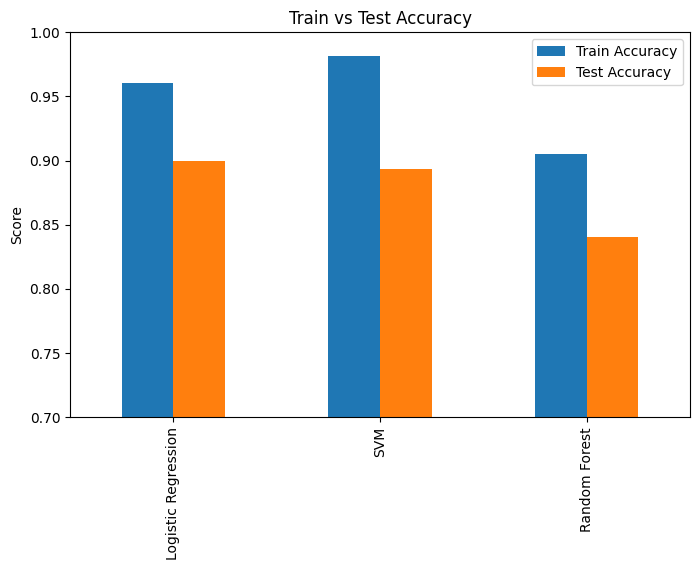

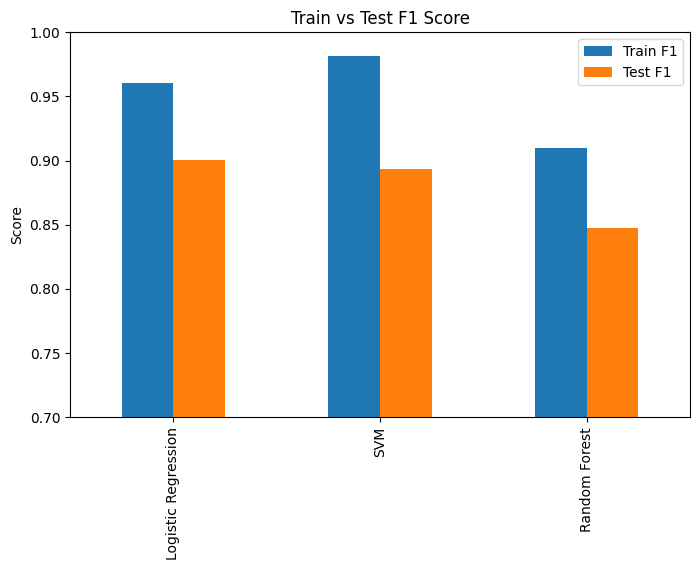

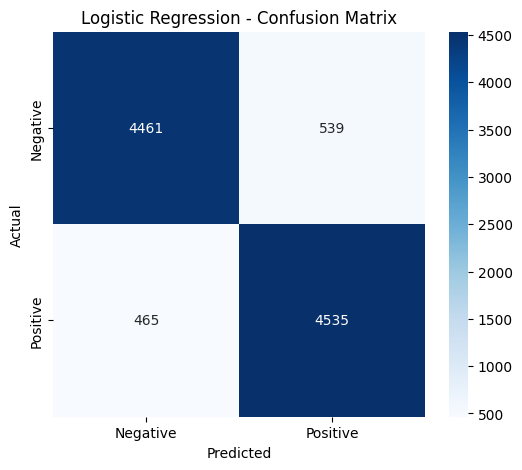

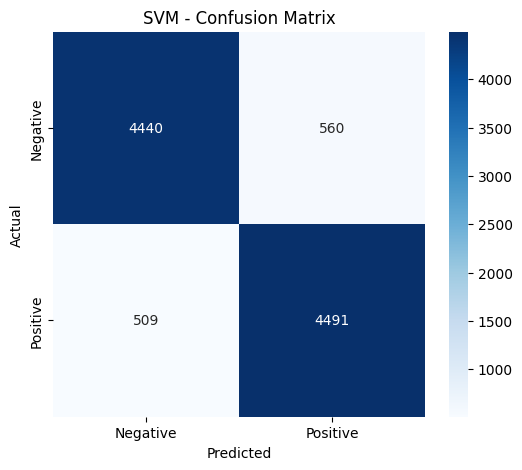

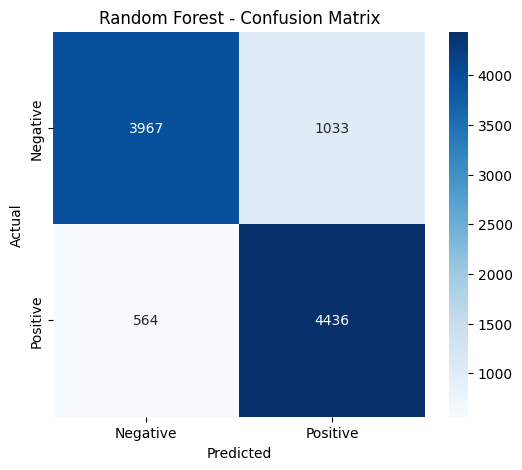

In [18]:
# === Comparison Table ===
results = {
    "Logistic Regression": [
        accuracy_score(y_test, lr_pred),
        precision_score(y_test, lr_pred),
        recall_score(y_test, lr_pred),
        f1_score(y_test, lr_pred)
    ],
    "SVM": [
        accuracy_score(y_test, svm_pred),
        precision_score(y_test, svm_pred),
        recall_score(y_test, svm_pred),
        f1_score(y_test, svm_pred)
    ],
    "Random Forest": [
        accuracy_score(y_test, rf_pred),
        precision_score(y_test, rf_pred),
        recall_score(y_test, rf_pred),
        f1_score(y_test, rf_pred)
    ]
}

results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1 Score"]).T
print("=== Model Comparison ===")
print(results_df)


# === Training vs Test Performance Plots ===
perf = {
    "Logistic Regression": {
        "Train Accuracy": accuracy_score(y_train, lr_pipe.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, lr_pred),
        "Train F1": f1_score(y_train, lr_pipe.predict(X_train)),
        "Test F1": f1_score(y_test, lr_pred),
    },
    "SVM": {
        "Train Accuracy": accuracy_score(y_train, svm_pipe.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, svm_pred),
        "Train F1": f1_score(y_train, svm_pipe.predict(X_train)),
        "Test F1": f1_score(y_test, svm_pred),
    },
    "Random Forest": {
        "Train Accuracy": accuracy_score(y_train, rf_pipe.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, rf_pred),
        "Train F1": f1_score(y_train, rf_pipe.predict(X_train)),
        "Test F1": f1_score(y_test, rf_pred),
    }
}

perf_df = pd.DataFrame(perf).T

perf_df[["Train Accuracy","Test Accuracy"]].plot(kind="bar", figsize=(8,5))
plt.title("Train vs Test Accuracy")
plt.ylabel("Score")
plt.ylim(0.7,1.0)
plt.show()

perf_df[["Train F1","Test F1"]].plot(kind="bar", figsize=(8,5))
plt.title("Train vs Test F1 Score")
plt.ylabel("Score")
plt.ylim(0.7,1.0)
plt.show()


# === Confusion Matrices ===
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, lr_pred, "Logistic Regression")
plot_confusion_matrix(y_test, svm_pred, "SVM")
plot_confusion_matrix(y_test, rf_pred, "Random Forest")
